## Geocoding
### Overview of Geocoders
Geocoding is the process of transforming place names or addresses into coordinates. In this lesson we will learn how to geocode addresses using Geopandas and geopy.

Geopy and other geocoding libaries (such as geocoder) make it easy to locate the coordinates of addresses, cities, countries, and landmarks across the globe using web services (“geocoders”). In practice, geocoders are often Application Programming Interfaces (APIs) where you can send requests, and receive responses in the form of place names, addresses and coordinates.

Geopy offers access to several geocoding services, including:
- ESRI ArcGIS

- Baidu Maps

- Bing

- GeocodeFarm

- GeoNames

- Google Geocoding API (V3)

- HERE

- IGN France

- Mapquest

- OpenCage

- OpenMapQuest

- Open Street Map Nominatim

- What3words

- Yandex

Check the geopy documentation for more details about how to use each service via Python.

As you see, there are plenty of geocoders where to choose from! The quality of the geocoders might differ depending on the underlying data. For example, some addresses might exists on OpenStreetMap, but not on Google Maps and thus they can be geocoded using the Nominatim geocoder, but not using the Google Geocoding API - and vice versa.

Geocoding services might require an API key in order to use them. (i.e. you need to register for the service before you can access results from their API). Furthermore, rate limiting also restrict the use of these services. The geocoding process might end up in an error if you are making too many requests in a short time period (eg. trying to geocode large number of addresses). See hints for dealing with rate limiting when geocoding pandas DataFrames from the geopy documentation. If you pay for the geocoding service, you can naturally make more requests to the API.

In this lesson we will use the Nominatim geocoder for locating a relatively small number of addresses. Usage of the Nominatim geocoding service is rate-limited to 1 request per second (3600 / hour). You can read more about Nominatim usage policy in here

Luckily, Nominatim, which is a geocoder based on OpenStreetMap data does not require a API key to use their service if it is used to geocode only a small number of addresses.

### Geocoding in Geopandas
It is possible to do geocoding in Geopandas through geopy. Geopandas has a function called geocode() that can geocode a list of addresses (strings) and return a GeoDataFrame containing the resulting point objects in geometry column.

Let’s try this out.

We will geocode addresses stored in a text file called addresses.txt. These addresses are located in the Helsinki Region in Southern Finland.

The first rows of the data look like this:

In [1]:
# Import necessary modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Filepath
fp = r"data/addresses.txt"

# Read the data
data = pd.read_csv(fp, sep=';')

In [2]:
data.head()

,id,addr
0,1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


### Geocode addresses using Nominatim
Now we have our data in a pandas DataFrame and we can geocode our addresses using the geopandas geocoding function that uses geopy package in the background.

- Let’s import the geocoding function and geocode the addresses (column addr) using Nominatim.

- Remember to provide a custom string (name of your application) in the user_agent parameter.

- If needed, you can add the timeout-parameter which specifies how many seconds we will wait for a response from the service.

In [3]:
# Import the geocoding tool
from geopandas.tools import geocode

# Geocode addresses using Nominatim. Remember to provide a custom "application name" in the user_agent parameter!
geo = geocode(data['addr'], provider='nominatim', user_agent='autogis_AB', timeout=4)

In [4]:
geo.head()

,geometry,address
0,POINT (24.91556 60.16320),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns..."
1,POINT (24.93166 60.16905),"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi..."
2,POINT (24.94179 60.16989),"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,..."
3,POINT (24.97783 60.18892),"Hermannin rantatie, Verkkosaari, Kalasatama, S..."
4,POINT (24.92160 60.15665),"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län..."


And Voilà! As a result we have a GeoDataFrame that contains our original address and a ‘geometry’ column containing Shapely Point -objects that we can use for exporting the addresses to a Shapefile for example. However, the id column is not there. Thus, we need to join the information from data into our new GeoDataFrame geo, thus making a Table Join.

#### Rate-limiting

When geocoding a large dataframe, you might encounter an error when geocoding. In case you get a time out error, try first using the timeout parameter as we did above (allow the service a bit more time to respond). In case of Too Many Requests error, you have hit the rate-limit of the service, and you should slow down your requests. To our convenience, geopy provides additional tools for taking into account rate limits in geocoding services. This script adapts the usage of geopy RateLimiter to our input data.
All in all, remember that Nominatim is not meant for super heavy use.

### Table join

Joining data between two or several tables is a common task in many (spatial) data analysis workflows. As you might remember from our earlier lessons, combining data from different tables based on common key attribute can be done easily in pandas/geopandas using the merge() -function. We used this approach in the geo-python course exercise 6.

However, sometimes it is useful to join two tables together based on the index of those DataFrames. In such case, we assume that there is same number of records in our DataFrames and that the order of the records should be the same in both DataFrames.

We can use this approach to join information from the original data to our geocoded addresses row-by-row join() -function which merges the two DataFrames together based on index by default. This approach works correctly because the order of the geocoded addresses in geo DataFrame is the same as in our original data DataFrame.

In [5]:
join = geo.join(data)
join.head()

,geometry,address,id,addr
0,POINT (24.91556 60.16320),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,POINT (24.93166 60.16905),"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi...",1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,POINT (24.94179 60.16989),"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,...",1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,POINT (24.97783 60.18892),"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,POINT (24.92160 60.15665),"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


As a result we have a new GeoDataFrame called join where we now have all original columns plus a new column for geometry. Note! If you would do the join the other way around, i.e. data.join(geo), the output would be a pandas DataFrame, not a GeoDataFrame!

Now it is easy to save our address points into a Shapefile

In [6]:
# Output file path
outfp = r"data/addresses.shp"

# Save to Shapefile
join.to_file(outfp)

### Notes about Nominatim
Nominatim works relatively nicely if you have well defined and well-known addresses such as the ones that we used in this tutorial. In practice, the address needs to exist in the OpenStreetMap database. Sometimes, however, you might want to geocode a “point-of-interest”, such as a museum, only based on it’s name. If the museum name is not on OpenStreetMap, Nominatim won’t provide any results for it, but you might be able to geocode the place using some other geocoder such as the Google Geocoding API (V3), which requires an API key. Take a look from past year’s materials where we show how to use Google Geocoding API in a similar manner as we used Nominatim here.

## Point in Polygon & Intersect
Finding out if a certain point is located inside or outside of an area, or finding out if a line intersects with another line or polygon are fundamental geospatial operations that are often used e.g. to select data based on location. Such spatial queries are one of the typical first steps of the workflow when doing spatial analysis. Performing a spatial join (will be introduced later) between two spatial datasets is one of the most typical applications where Point in Polygon (PIP) query is used.

For further reading about PIP and other geometric operations, see Chapter 4.2 in Smith, Goodchild & Longley: Geospatial Analysis - 6th edition.

### How to check if point is inside a polygon?
Computationally, detecting if a point is inside a polygon is most commonly done using a specific formula called Ray Casting algorithm. Luckily, we do not need to create such a function ourselves for conducting the Point in Polygon (PIP) query. Instead, we can take advantage of Shapely’s binary predicates that can evaluate the topolocical relationships between geographical objects, such as the PIP as we’re interested here.

There are basically two ways of conducting PIP in Shapely:

1. using a function called within() that checks if a point is within a polygon

2. using a function called contains() that checks if a polygon contains a point

Notice: even though we are talking here about Point in Polygon operation, it is also possible to check if a LineString or Polygon is inside another Polygon.

Let’s import shapely functionalities and create some points:

In [1]:
from shapely.geometry import Point, Polygon

# Create Point objects
p1 = Point(24.952242, 60.1696017)
p2 = Point(24.976567, 60.1612500)

# Let’s also create a polygon using a list of coordinate-tuples:

# Create a Polygon
coords = [(24.950899, 60.169158), (24.953492, 60.169158), (24.953510, 60.170104), (24.950958, 60.169990)]
poly = Polygon(coords)

# Let’s check if those points are within the polygon:

# Check if p1 is within the polygon using the within function
print(p1.within(poly))

# Check if p2 is within the polygon
print(p2.within(poly))

True
False


Okey, so we can see that the first point seems to be inside that polygon and the other one isn’t.
- In fact, the first point is quite close to close to the center of the polygon as we can see if we compare the point location to the polygon centroid:

In [2]:
# Our point
print(p1)

# The centroid
print(poly.centroid)

# It is also possible to do PIP other way around, i.e. to check if polygon contains a point:

print(poly.contains(p1))
print(poly.contains(p2))

POINT (24.952242 60.1696017)
POINT (24.952242428492358 60.16960179038188)
True
False


Thus, both ways of checking the spatial relationship are identical; contains() is inverse to within() and vice versa.

Which one should you use then? Well, it depends:

- if you have many points and just one polygon and you try to find out which one of them is inside the polygon: You might need to iterate over the points and check one at a time if it is within() the polygon.

- if you have many polygons and just one point and you want to find out which polygon contains the point: You might need to iterate over the polygons until you find a polygon that contains() the point specified (assuming there are no overlapping polygons)

### Intersect
Another typical geospatial operation is to see if a geometry intersects or touches another one. Again, there are binary operations in Shapely for checking these spatial relationships:

- intersects(): Two objects intersect if the boundary or interior of one object intersect in any way with the boundary or interior of the other object.

- touches(): Two objects touch if the objects have at least one point in common and their interiors do not intersect with any part of the other object.

Let’s try these out.

Let’s create two LineStrings:

In [3]:
from shapely.geometry import LineString, MultiLineString

# Create two lines
line_a = LineString([(0, 0), (1, 1)])
line_b = LineString([(1, 1), (0, 2)])

print(line_a.intersects(line_b))
print(line_a.touches(line_b))

True
True


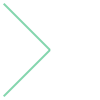

In [4]:
# Create a MultiLineString from line_a and line_b
multi_line = MultiLineString([line_a, line_b])
multi_line

Thus, the line_b continues from the same node ( (1,1) ) where line_a ends.

However, if the lines overlap fully, they don’t touch due to the spatial relationship rule, as we can see:

Check if line_a touches itself:

In [5]:
# Does the line touch with itself?
print(line_a.touches(line_a))

# Does the line intersect with itself?
print(line_a.intersects(line_a))

False
True


### Point in Polygon using Geopandas
Next we will do a practical example where we check which of the addresses from the geocoding tutorial are located in Southern district of Helsinki. Let’s start by reading a KML-file PKS_suuralue.kml that has the Polygons for districts of Helsinki Region (data openly available from Helsinki Region Infoshare.

Let’s start by reading the addresses from the Shapefile that we saved earlier.

In [6]:
import geopandas as gpd

fp = "data/addresses.shp"
data = gpd.read_file(fp)

data.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93166 60.16905)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97783 60.18892)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)


### Reading KML-files in Geopandas
It is possible to read the data from KML-files with GeoPandas in a similar manner as Shapefiles. However, we need to first, enable the KML-driver which is not enabled by default (because KML-files can contain unsupported data structures, nested folders etc., hence be careful when reading KML-files). Supported drivers are managed with fiona.supported_drivers, which is integrated in geopandas. Let’s first check which formats are currently supported:

In [7]:
import geopandas as gpd
gpd.io.file.fiona.drvsupport.supported_drivers

{'ARCGEN': 'r',
 'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'rw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'GPSTrackMaker': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'rw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

Let’s enable the read and write functionalities for KML-driver by passing 'rw' to whitelist of fiona’s supported drivers:

In [9]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
gpd.io.file.fiona.drvsupport.supported_drivers

{'ARCGEN': 'r',
 'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'rw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'GPSTrackMaker': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'rw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r',
 'KML': 'rw'}

Now we should be able to read a KML file using the geopandas read_file() function.

Let’s read district polygons from a KML -file that is located in the data-folder:

In [10]:
# Filepath to KML file
fp = "data/PKS_suuralue.kml"
polys = gpd.read_file(fp, driver='KML')

In [11]:
#Check the data
print(f"Number of rows: {len(polys)}")
polys.head(11)

Number of rows: 23


,Name,Description,geometry
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766..."
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155..."
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752..."
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699..."
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537..."
5,Kauniainen,,"POLYGON Z ((24.69075 60.21958 0.00000, 24.6924..."
6,Suur-Leppävaara,,"POLYGON Z ((24.79747 60.20827 0.00000, 24.7954..."
7,Suur-Tapiola,,"POLYGON Z ((24.84436 60.16598 0.00000, 24.8443..."
8,Myyrmäki,,"POLYGON Z ((24.82459 60.29025 0.00000, 24.8243..."
9,Kivistö,,"POLYGON Z ((24.94309 60.33845 0.00000, 24.9421..."


<AxesSubplot:>

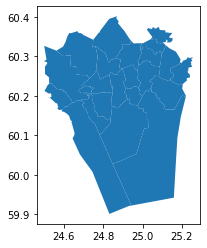

In [12]:
polys.plot()

We are interested in an area that is called Eteläinen (‘Southern’ in English).

Let’s select the Eteläinen district and see where it is located on a map:

In [22]:
# Select data 
southern = polys.loc[polys['Name']=='Eteläinen']

In [23]:
southern

,Name,Description,geometry
10,Eteläinen,,"POLYGON Z ((24.78277 60.09997 0.00000, 24.8197..."


In [24]:
# Reset index for the selection
southern.reset_index(drop=True, inplace=True)

In [25]:
southern

,Name,Description,geometry
0,Eteläinen,,"POLYGON Z ((24.78277 60.09997 0.00000, 24.8197..."


Let’s create a map which shows the location of the selected district, and let’s also plot the geocoded address points on top of the map:

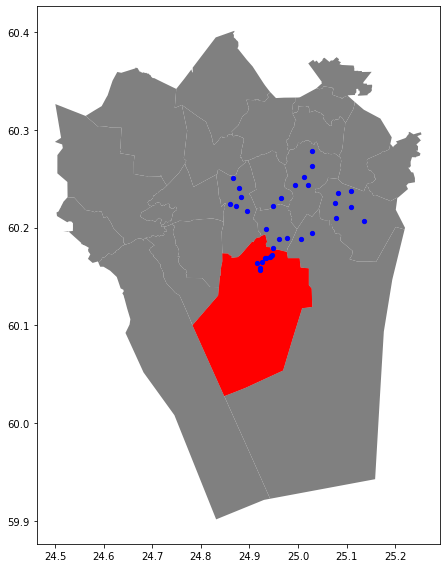

In [32]:
import matplotlib.pyplot as plt

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(8,8))

# Plot polygons
polys.plot(ax=ax, facecolor='gray')
southern.plot(ax=ax, facecolor='red')

# Plot points
data.plot(ax=ax, color='blue', markersize=18)

plt.tight_layout()

Okey, so we can see that, indeed, certain points are within the selected red Polygon.

Let’s find out which one of them are located within the Polygon. Hence, we are conducting a Point in Polygon query.

First, let’s check that we have shapely.speedups enabled. This module makes some of the spatial queries running faster (starting from Shapely version 1.6.0 Shapely speedups are enabled by default):

In [34]:
#import shapely.speedups
from shapely import speedups
speedups.enabled

# If false, run this line:
#shapely.speedups.enable()

True

Let’s check which Points are within the southern Polygon. Notice, that here we check if the Points are within the geometry of the southern GeoDataFrame.

We use the .at[0, 'geometry'] to parse the actual Polygon geometry object from the GeoDataFrame.

In [40]:
pip_mask = data.within(southern.at[0,'geometry'])
print(pip_mask)

0      True
1      True
2      True
3     False
4      True
5     False
6     False
7     False
8     False
9     False
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30     True
31     True
32     True
33     True
dtype: bool


As we can see, we now have an array of boolean values for each row, where the result is True if Point was inside the Polygon, and False if it was not.

We can now use this mask array to select the Points that are inside the Polygon. Selecting data with this kind of mask array (of boolean values) is easy by passing the array inside the loc indexer:

In [41]:
pip_data = data.loc[pip_mask]
pip_data

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93166 60.16905)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)
10,"Rautatientori, Kluuvi, Keskusta, Eteläinen suu...",1011,"Rautatientori 1, 00100 Helsinki, Finland",POINT (24.94410 60.17133)
30,"Kampin keskus, 1, Urho Kekkosen katu, Kamppi, ...",1031,"Urho Kekkosen katu 1, 00100 Helsinki, Finland",POINT (24.93312 60.16909)
31,"Ruoholahdenkatu, Hietalahti, Kamppi, Eteläinen...",1032,"Ruoholahdenkatu 17, 00101 Helsinki, Finland",POINT (24.92496 60.16497)
32,"Fitness online, 3, Tyynenmerenkatu, Jätkäsaari...",1033,"Tyynenmerenkatu 3, 00220 Helsinki, Finland",POINT (24.92119 60.15903)
33,"Oluthuone Kaisla, 4, Vilhonkatu, Kluuvi, Kesku...",1034,"Vilhonkatu 4, 00101 Helsinki, Finland",POINT (24.94709 60.17191)


Let’s finally confirm that our Point in Polygon query worked as it should by plotting the points that are within the southern district:

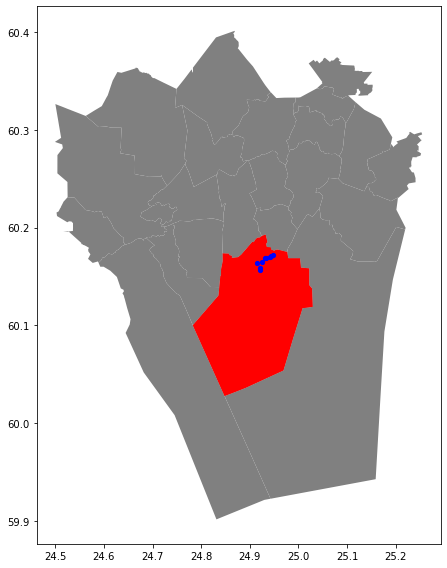

In [43]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(8,8))

# Plot polygons
polys.plot(ax=ax, facecolor='gray')
southern.plot(ax=ax, facecolor='red')

# Plot points
pip_data.plot(ax=ax, color='blue', markersize=18)

plt.tight_layout()

## Spatial join
Spatial join is yet another classic GIS problem. Getting attributes from one layer and transferring them into another layer based on their spatial relationship is something you most likely need to do on a regular basis.

In the previous section we learned how to perform a Point in Polygon query. We can now use the same logic to conduct a spatial join between two layers based on their spatial relationship. We could, for example, join the attributes of a polygon layer into a point layer where each point would get the attributes of a polygon that contains the point.

Luckily, spatial join is already implemented in Geopandas, thus we do not need to create our own function for doing it. There are three possible types of join that can be applied in spatial join that are determined with op -parameter in the gpd.sjoin() -function:

- "intersects"

- "within"

- "contains"

Sounds familiar? Yep, all of those spatial relationships were discussed in the Point in Polygon lesson, thus you should know how they work.

Furthermore, pay attention to the different options for the type of join via the how parameter; “left”, “right” and “inner”. You can read more about these options in the geopandas sjoin documentation and pandas guide for merge, join and concatenate

Let’s perform a spatial join between these two layers:

- Addresses: the geocoded address-point (we created this Shapefile in the geocoding tutorial)

- Population grid: 250m x 250m grid polygon layer that contains population information from the Helsinki Region.

    - The population grid a dataset is produced by the Helsinki Region Environmental Services Authority (HSY) (see this page to access data from different years).

    - You can download the data from from this link in the Helsinki Region Infroshare (HRI) open data portal.

- Here, we will access the data directly from the HSY wfs:

In [45]:
import geopandas as gpd
from pyproj import CRS
import requests
import geojson

proxies = {
 "http": "http://10.1.10.99:8080",
 "https": "http://10.1.10.99:8080"
}

# Specify the url for web feature service
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format). 
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018', 
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params, proxies=proxies)

# Create GeoDataFrame from geojson
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))


In [46]:
pop.head()

,geometry,index,asukkaita,asvaljyys,ika0_9,ika10_19,ika20_29,ika30_39,ika40_49,ika50_59,ika60_69,ika70_79,ika_yli80
0,"POLYGON ((25472499.995 6689749.005, 25472499.9...",688,9,28.0,99,99,99,99,99,99,99,99,99
1,"POLYGON ((25472499.995 6685998.998, 25472499.9...",703,5,51.0,99,99,99,99,99,99,99,99,99
2,"POLYGON ((25472499.995 6684249.004, 25472499.9...",710,8,44.0,99,99,99,99,99,99,99,99,99
3,"POLYGON ((25472499.995 6683999.005, 25472499.9...",711,5,90.0,99,99,99,99,99,99,99,99,99
4,"POLYGON ((25472499.995 6682998.998, 25472499.9...",715,11,41.0,99,99,99,99,99,99,99,99,99


Okey so we have multiple columns in the dataset but the most important one here is the column asukkaita (“population” in Finnish) that tells the amount of inhabitants living under that polygon.

- Let’s change the name of that column into pop18 so that it is more intuitive. As you might remember, we can easily rename (Geo)DataFrame column names using the rename() function where we pass a dictionary of new column names like this: columns={'oldname': 'newname'}.

In [51]:
# Change the name of a column
pop = pop.rename(columns={'asukkaita': 'pop18'})

# Let’s also get rid of all unnecessary columns by selecting only columns that we need i.e. pop18 and geometry

# Subset columns
pop = pop[["pop18", "geometry"]]

pop.head()

,pop18,geometry
0,9,"POLYGON ((25472499.995 6689749.005, 25472499.9..."
1,5,"POLYGON ((25472499.995 6685998.998, 25472499.9..."
2,8,"POLYGON ((25472499.995 6684249.004, 25472499.9..."
3,5,"POLYGON ((25472499.995 6683999.005, 25472499.9..."
4,11,"POLYGON ((25472499.995 6682998.998, 25472499.9..."


### Join the layers
Now we are ready to perform the spatial join between the two layers that we have. The aim here is to get information about **how many people live in a polygon that contains an individual address-point**. Thus, we want to join attributes from the population layer we just modified into the addresses point layer addresses.shp that we created trough gecoding in the previous section.

Read the addresses layer into memory:

In [53]:
# Addresses filpath
addr_fp = r"data/addresses.shp"

# Read data
addresses = gpd.read_file(addr_fp)

# Check the head of the file
addresses.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93166 60.16905)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97783 60.18892)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)


In order to do a spatial join, the layers need to be in the same projection

Check the crs of input layers:

In [54]:
addresses.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [56]:
# If the crs information is missing from the population grid, we can define the coordinate reference system as ETRS GK-25 (EPSG:3879) because we know what it is based on the population grid metadata.

# Define crs
pop.crs = CRS.from_epsg(3879).to_wkt()

pop.crs

<Derived Projected CRS: EPSG:3879>
Name: ETRS89 / GK25FIN
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Finland - nominally onshore between 24°30'E and 25°30'E but may be used in adjacent areas if a municipality chooses to use one zone over its whole extent.
- bounds: (24.5, 59.94, 25.5, 68.9)
Coordinate Operation:
- name: Finland Gauss-Kruger zone 25
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [57]:
# Are the layers in the same projection?
addresses.crs == pop.crs

False

In [58]:
# Let’s re-project addresses to the projection of the population layer:
addresses = addresses.to_crs(pop.crs)

In [59]:
# Check the crs of address points
print(addresses.crs)

# Check the crs of population layer
print(pop.crs)

# Do they match now?
addresses.crs == pop.crs

PROJCRS["ETRS89 / GK25FIN",BASEGEOGCRS["ETRS89",ENSEMBLE["European Terrestrial Reference System 1989 ensemble",MEMBER["European Terrestrial Reference Frame 1989"],MEMBER["European Terrestrial Reference Frame 1990"],MEMBER["European Terrestrial Reference Frame 1991"],MEMBER["European Terrestrial Reference Frame 1992"],MEMBER["European Terrestrial Reference Frame 1993"],MEMBER["European Terrestrial Reference Frame 1994"],MEMBER["European Terrestrial Reference Frame 1996"],MEMBER["European Terrestrial Reference Frame 1997"],MEMBER["European Terrestrial Reference Frame 2000"],MEMBER["European Terrestrial Reference Frame 2005"],MEMBER["European Terrestrial Reference Frame 2014"],ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[0.1]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4258]],CONVERSION["Finland Gauss-Kruger zone 25",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.

True

Now they should be identical. Thus, we can be sure that when doing spatial queries between layers the locations match and we get the right results e.g. from the spatial join that we are conducting here.

- Let’s now join the attributes from pop GeoDataFrame into addresses GeoDataFrame by using gpd.sjoin() -function:

In [60]:
# Make a spatial join
join = gpd.sjoin(addresses, pop, how="inner", op="within")

C:\Users\alfoldybalint\.conda\envs\python_gis\lib\site-packages\IPython\core\interactiveshell.py:3191: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [61]:
join.head()

,address,id,addr,geometry,index_right,pop18
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (25495311.608 6672258.695),3252,515
1,"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (25496206.216 6672909.016),3364,182
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (25496768.622 6673002.004),3488,38
10,"Rautatientori, Kluuvi, Keskusta, Eteläinen suu...",1011,"Rautatientori 1, 00100 Helsinki, Finland",POINT (25496896.734 6673162.114),3488,38
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (25498769.713 6675121.127),3822,61


Awesome! Now we have performed a successful spatial join where we got two new columns into our join GeoDataFrame, i.e. index_right that tells the index of the matching polygon in the population grid and pop18 which is the population in the cell where the address-point is located.

Let’s still check how many rows of data we have now:

In [64]:
print(len(join))
print(len(addresses))

31
34


If we plot the layers on top of each other, we can observe that some of the points are located outside the populated grid squares (increase figure size if you can’t see this properly!)

<AxesSubplot:>

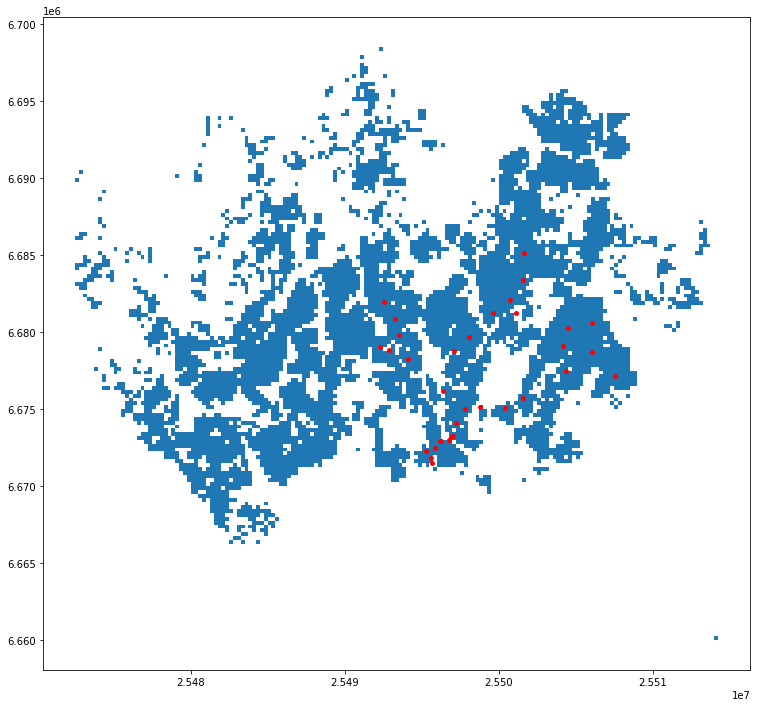

In [67]:
import matplotlib.pyplot as plt

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,12))

# Plot population grid
pop.plot(ax=ax)

# Plot points
addresses.plot(ax=ax, color='red', markersize=15)

Let’s also visualize the joined output:

Plot the points and use the pop18 column to indicate the color. cmap -parameter tells to use a sequential colormap for the values, markersize adjusts the size of a point, scheme parameter can be used to adjust the classification method based on pysal, and legend tells that we want to have a legend:

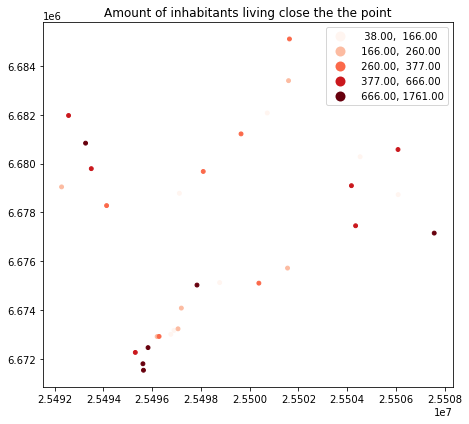

In [70]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10,6))

# Plot the points with population info
join.plot(ax=ax, column='pop18', cmap="Reds", markersize=15, scheme='quantiles', legend=True);

# Add title
plt.title("Amount of inhabitants living close the the point");

# Remove white space around the figure
plt.tight_layout()

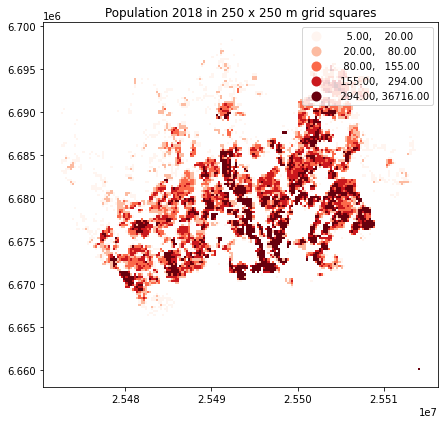

In [72]:
# In a similar way, we can plot the original population grid and check the overall population distribution in Helsinki:

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10,6))

# Plot the grid with population info
pop.plot(ax=ax, column='pop18', cmap="Reds", scheme='quantiles', legend=True);

# Add title
plt.title("Population 2018 in 250 x 250 m grid squares");

# Remove white space around the figure
plt.tight_layout()

In [73]:
# Output path
outfp = r"data/addresses_population.shp"

# Save to disk
join.to_file(outfp)

C:\Users\alfoldybalint\AppData\Local\Temp\ipykernel_11580\218676674.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  join.to_file(outfp)


## Nearest Neighbour Analysis
One commonly used GIS task is to be able to find the nearest neighbour for an object or a set of objects. For instance, you might have a single Point object representing your home location, and then another set of locations representing e.g. public transport stops. Then, quite typical question is “which of the stops is closest one to my home?” This is a typical nearest neighbour analysis, where the aim is to find the closest geometry to another geometry.

In Python this kind of analysis can be done with shapely function called nearest_points() that returns a tuple of the nearest points in the input geometries.

### Nearest point using Shapely
Let’s start by testing how we can find the nearest Point using the nearest_points() function of Shapely.

Let’s create an origin Point and a few destination Points and find out the closest destination:

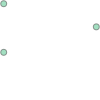

In [2]:
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

# Origin point
orig = Point(1, 1.67)

# Destination points
dest1 = Point(0, 1.45)
dest2 =Point(2, 2)
dest3 = Point(0, 2.5)

# To be able to find out the closest destination point from the origin, we need to create a MultiPoint object from the destination points.
destinations = MultiPoint([dest1, dest2, dest3])
destinations

In [5]:
# Now we can find out the nearest destination point by using nearest_points() function:
nearest_geoms = nearest_points(orig, destinations)
type(nearest_geoms)

tuple

In [6]:
print(nearest_geoms)

(<shapely.geometry.point.Point object at 0x0000014D96C5B190>, <shapely.geometry.point.Point object at 0x0000014D96CDF550>)


In [9]:
print(nearest_geoms[0])

POINT (1 1.67)


In [10]:
print(nearest_geoms[1])

POINT (0 1.45)


### Nearest points using Geopandas
Let’s then see how it is possible to find nearest points from a set of origin points to a set of destination points using GeoDataFrames. Here, we will use the PKS_suuralueet.kml district data, and the addresses.shp address points from previous sections.

**Our goal in this tutorial is to find out the closest address to the centroid of each district.**

Let’s first read in the data and check their structure:

In [14]:
# Import geopandas
import geopandas as gpd

# Define filepaths
fp1 = "data/PKS_suuralue.kml"
fp2 = "data/addresses.shp"

# Enable KML driver
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# Read in data with geopandas
df1 = gpd.read_file(fp1, driver='KML')
df2 = gpd.read_file(fp2)

# District polygons:
df1.head()

,Name,Description,geometry
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766..."
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155..."
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752..."
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699..."
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537..."


In [15]:
# Address points:
df2.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93166 60.16905)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97783 60.18892)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)


In [17]:
# Before calculating any distances, we should re-project the data into a projected crs.
df1 = df1.to_crs(epsg=3067)
df2 = df2.to_crs(epsg=3067)

# Furthermore, let’s calculate the centroids for each district area:
df1['centroid'] = df1.centroid
df1.head()

,Name,Description,geometry,centroid
0,Suur-Espoonlahti,,"POLYGON ((376322.317 6665639.417, 376401.244 6...",POINT (375676.529 6658405.261)
1,Suur-Kauklahti,,"POLYGON ((367726.077 6673018.023, 367715.245 6...",POINT (365520.906 6675893.101)
2,Vanha-Espoo,,"POLYGON ((371207.712 6677289.881, 371174.739 6...",POINT (367400.175 6681941.088)
3,Pohjois-Espoo,,"POLYGON ((376528.523 6683480.345, 376638.253 6...",POINT (372191.037 6687785.458)
4,Suur-Matinkylä,,"POLYGON ((375347.271 6672052.630, 375354.852 6...",POINT (375678.189 6670243.076)


SO, for each row of data in the disctricts -table, we want to figure out the nearest address point and fetch some attributes related to that point. In other words, we want to apply the Shapely nearest_pointsfunction so that we compare each polygon centroid to all address points, and based on this information access correct attribute information from the address table.

For doing this, we can create a function that we will apply on the polygon GeoDataFrame:

In [19]:
unary_union = df2.unary_union
print(unary_union)

MULTIPOINT (381505.3519674061 6678285.881515038, 381880.4108452512 6681202.537438168, 382114.9792119076 6678084.618272202, 382542.959824382 6680048.502006705, 382745.2925349261 6678996.642557419, 383326.41467843635 6677463.572679196, 384320.89827964845 6671412.394772961, 384618.38487654505 6670937.937219749, 384632.93678170093 6670672.153797519, 384848.3420622938 6671593.314176844, 385234.57067530986 6672035.18146947, 385315.3532032097 6672037.488103471, 385486.63769903884 6675317.531513787, 385799.3988146852 6672111.07961222, 385932.26792768284 6672267.199360553, 386100.1179494156 6672326.634806169, 386261.8576263266 6673171.956396541, 386323.7502928812 6677878.715123225, 386931.4983202177 6674095.571714901, 387329.01954235986 6678742.357557865, 387863.24378798646 6674168.130442299, 388924.30183989904 6680234.979897246, 389469.44169960066 6674096.854469957, 390024.58270165697 6681059.205512979, 390419.00094183005 6680179.263382102, 390662.98644965864 6674679.071426063, 390936.70882654

In [22]:
def get_nearest_values(row, other_gdf, point_column='geometry', value_column="geometry"):
    """Find the nearest point and return the corresponding value from specified value column."""
    
    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf["geometry"].unary_union
    
    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)
    
    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf["geometry"] == nearest_geoms[1]]
    
    nearest_value = nearest_data[value_column].values[0]
    
    return nearest_value

By default, this function returns the geometry of the nearest point for each row. It is also possible to fetch information from other columns by changing the value_column parameter.

The function creates a MultiPoint object from other_gdf geometry column (in our case, the address points) and further passes this MultiPoint object to Shapely’s nearest_points function.

Here, we are using a method for creating an union of all input geometries called unary_union.

Okey now we are ready to use our function and find closest address point for each polygon centroid.

Try first applying the function without any additional modifications:

In [23]:
df1["nearest_loc"] = df1.apply(get_nearest_values, other_gdf=df2, point_column="centroid", axis=1)

C:\Users\alfoldybalint\.conda\envs\python_gis\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [27]:
# Finally, we can specify that we want the id -column for each point, and store the output in a new column "nearest_loc":
df1["nearest_loc"] = df1.apply(get_nearest_values, other_gdf=df2, point_column="centroid", value_column="id", axis=1)

In [29]:
df1.head()

,Name,Description,geometry,centroid,nearest_loc
0,Suur-Espoonlahti,,"POLYGON ((376322.317 6665639.417, 376401.244 6...",POINT (375676.529 6658405.261),1005
1,Suur-Kauklahti,,"POLYGON ((367726.077 6673018.023, 367715.245 6...",POINT (365520.906 6675893.101),1020
2,Vanha-Espoo,,"POLYGON ((371207.712 6677289.881, 371174.739 6...",POINT (367400.175 6681941.088),1017
3,Pohjois-Espoo,,"POLYGON ((376528.523 6683480.345, 376638.253 6...",POINT (372191.037 6687785.458),1017
4,Suur-Matinkylä,,"POLYGON ((375347.271 6672052.630, 375354.852 6...",POINT (375678.189 6670243.076),1000


## Spatial index - How to boost spatial queries?
While using the technique from previous examples produces correct results, it is in fact quite slow from performance point of view. Especially when having large datasets (quite typical nowadays), the point in polygon queries can become frustratingly slow, which can be a nerve-racking experience for a busy geo-data scientist.

Luckily there is an easy and widely used solution called spatial index that can significantly boost the performance of your spatial queries. Various alternative techniques has been developed to boost spatial queries, but one of the most popular one and widely used is a spatial index based on R-tree data structure.

The core idea behind the R-tree is to form a tree-like data structure where nearby objects are grouped together, and their geographical extent (minimum bounding box) is inserted into the data structure (i.e. R-tree). This bounding box then represents the whole group of geometries as one level (typically called as “page” or “node”) in the data structure. This process is repeated several times, which produces a tree-like structure where different levels are connected to each other. This structure makes the query times for finding a single object from the data much faster, as the algorithm does not need to travel through all geometries in the data. In the example below, we can see how the geometries have been grouped into several sub-groups (lower part of the picture) and inserted into a tree structure (upper part) where there exists two groups on the highest level (R1 and R2), which are again grouped into five lower level groups (R3-R7).

In the next tutorial we will learn how to significantly improve the query times for finding points that are within a given polygon. We will use data that represents all road intersections in the Uusimaa Region of Finland, and count the number of intersections on a postal code level. Why would you do such a thing?, well, one could for example try to understand the vitality of city blocks following Jane Jacobs’ ideas.

### Spatial index with Geopandas
In this tutorial, we will first go through a step by step example showing how spatial index works, and in the end we put things together and produce a practical function for doing fast spatial queries.

Let’s start by reading data representing road intersections (parsed from Digiroad road network data) and postal code areas (obtained from Statistics Finland). In this time, we will read the data from Geopackage files:

In [31]:
import geopandas as gpd

# Filepaths
intersections_fp = "data/uusimaa_intersections.gpkg"
postcode_areas_fp = "data/uusimaa_postal_code_areas.gpkg"

intersections = gpd.read_file(intersections_fp)
postcode_areas = gpd.read_file(postcode_areas_fp)

# Let's check first rows
print(intersections.head())
print('-----------')
print(postcode_areas.head())

            x            y                        geometry
0  330888.502  6675829.949  POINT (330888.502 6675829.949)
1  348059.990  6670041.685  POINT (348059.990 6670041.685)
2  348022.592  6670202.858  POINT (348022.592 6670202.858)
3  297208.220  6669048.357  POINT (297208.220 6669048.357)
4  330835.341  6675586.834  POINT (330835.341 6675586.834)
-----------
  posti_alue  he_vakiy                                           geometry
0      00100   18284.0  MULTIPOLYGON (((385653.893 6671591.048, 385573...
1      00120    7108.0  MULTIPOLYGON (((385316.092 6671076.984, 385279...
2      00130    1508.0  MULTIPOLYGON (((386212.111 6671061.262, 386176...
3      00140    7865.0  MULTIPOLYGON (((386577.050 6670280.544, 386552...
4      00150    9496.0  MULTIPOLYGON (((384846.102 6669565.816, 384823...


In [32]:
print(f"Number of intersections: {len(intersections)}")
print(f"Number of postal code areas: {len(postcode_areas)}")

Number of intersections: 63518
Number of postal code areas: 370


Okay, as we can see there are 63.5 thousand intersections in the region and 370 postal code areas. These are not yet huge datasets, but big enough so that we can see the benefits in using a spatial index.

Let’s still explore quickly how our datasets look on a map before doing the point in polygon queries.

(6667500.0, 6680000.0)

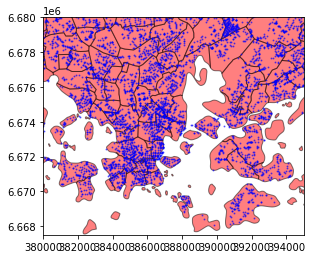

In [33]:
%matplotlib inline
ax = postcode_areas.plot(color='red', edgecolor='black', alpha=0.5)
ax = intersections.plot(ax=ax, color='blue', markersize=1, alpha=0.5)

# Zoom to closer (comment out the following to see the full extent of the data)
ax.set_xlim([380000, 395000])
ax.set_ylim([6667500, 6680000])

As we can see from the map, we have a large number of points (intersections) that are scattered around the city.

Next, we want to calculate how many of those points are inside each postal code area visible on the map. For doing this, we are going to take advantage of spatial index.

Building a spatial index for GeoDataFrame is easy in Geopandas. We can extract that by calling an attribute .sindex.

In [34]:
# Let's build spatial index for intersection points
intersection_sindex = intersections.sindex

# Let's see what it is
intersection_sindex

Okay, as we can see the variable contains a SpatialIndex object. Fundamentally, this object contains now the geometries in an R-tree data structure as introduced in the beginning of this page.

For conducting fast spatial queries, we can utilize the spatial index of the intersections, and compare the geometry of a given postal code area to the bounding boxes of points inside the R-tree spatial index. Let’s start with a single postal code area, to keep things simple.

<AxesSubplot:>

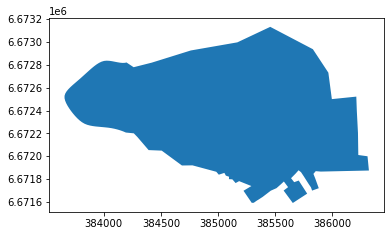

In [36]:
# Select a postal code area representing the city center of Helsinki
city_center_zip_area = postcode_areas.loc[postcode_areas['posti_alue']=='00100']
city_center_zip_area.plot()

Okay, now we can make a spatial query in which we want to select all the points, that are inside this Polygon. We conduct the point in polygon query in two steps:

- first, we compare the bounds of the Polygon into the spatial index of the Points. This gives us point candidates that are likely to be within the Polygon (at this stage based on the MBR of the points that is stored inside the R-tree).

- secondly, we go through the candidate points and make a normal spatial intersection query that gives us the accurate results:

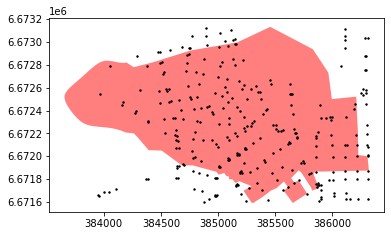

In [42]:
# Get the bounding box coordinates of the Polygon as a list
bounds = list(city_center_zip_area.bounds.values[0])

# Get the indices of the Points that are likely to be inside the bounding box of the given Polygon
point_candidate_idx = list(intersection_sindex.intersection(bounds))
point_candidates = intersections.loc[point_candidate_idx]

# Let's see what we have now
ax = city_center_zip_area.plot(color='red', alpha=0.5)
ax = point_candidates.plot(ax=ax, color='black', markersize=2)

Aha, as we can see, now we have successfully selected such points from the dataset that intersect with the bounding box of the Polygon. I.e. we conducted the first step of the process.

Next, let’s do the final selection using a “normal” intersect query, which is however, much faster because there is no need to go through all 63.5 thousand points in the full dataset:

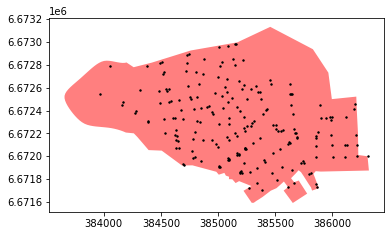

In [44]:
# Make the precise Point in Polygon query
final_selection = point_candidates.loc[point_candidates.intersects(city_center_zip_area['geometry'].values[0])]

# Let's see what we have now
ax = city_center_zip_area.plot(color='red', alpha=0.5)
ax = final_selection.plot(ax=ax, color='black', markersize=2)

### Putting pieces together - Performance comparisons
Following functions both conduct the spatial query that we saw previously, the first one without utilizing spatial index and the second one with spatial index. We can use them and compare the performance, so that we can get an idea how much the spatial index affects the performance time-wise.

In [46]:
def intersect_using_spatial_index(source_gdf, intersecting_gdf):
    """
    Conduct spatial intersection using spatial index for candidates GeoDataFrame to make queries faster.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points 
    intersect with ANY of those geometries.
    """
    source_sindex = source_gdf.sindex
    possible_matches_index = []
    
    # 'itertuples()' function is a faster version of 'iterrows()'
    for other in intersecting_gdf.itertuples():
        bounds = other.geometry.bounds
        c = list(source_sindex.intersection(bounds))
        possible_matches_index += c
    
    # Get unique candidates
    unique_candidate_matches = list(set(possible_matches_index))
    possible_matches = source_gdf.iloc[unique_candidate_matches]

    # Conduct the actual intersect
    result = possible_matches.loc[possible_matches.intersects(intersecting_gdf.unary_union)]
    return result

def normal_intersect(source_gdf, intersecting_gdf):
    """
    Conduct spatial intersection without spatial index.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points 
    intersect with ANY of those geometries.
    """
    
    matches = []
    
    # 'itertuples()' function is a faster version of 'iterrows()'
    for other in intersecting_gdf.itertuples():
        c = list(source_gdf.loc[source_gdf.intersects(other.geometry)].index)
        matches += c
    
    # Get all points that are intersecting with the Polygons
    unique_matches = list(set(matches))
    result = source_gdf.loc[source_gdf.index.isin(unique_matches)]
    return result

Let’s compare their performance and time it. Here we utilize a special IPython magic function called %timeit that allows to test how long it takes to run a specific function (it actually runs the function multiple times to get a more representative timing).

In [47]:
# Test the spatial query with spatial index
%timeit intersect_using_spatial_index(source_gdf=intersections, intersecting_gdf=city_center_zip_area)

10.4 ms ± 61.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
# Test the spatial query without spatial index
%timeit normal_intersect(source_gdf=intersections, intersecting_gdf=city_center_zip_area)

13 ms ± 371 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Making the spatial query only with a single Polygon (as in the example) might not make a big difference, but having hundreds or thousands of Polygons, and wanting to find all points that are inside those ones, start to make a drastic difference.

### Counting the intersections
The ultimate goal of this tutorial was to count the intersections per postal code. We can do that easily and fast with Geopandas, by conducting a spatial join between the two datasets. Spatial join in Geopandas is highly performant, and in fact, it utilizes spatial index to make the queries fast. The following parts might include a bit advanced tricks that we have not covered, but for the sake of completeness, the following steps count the intersections per postal code area. Finally, we plot a density of the intersections as a number of intersections per square kilometer (per postal code area).

In [61]:
# Count intersections by postal code area
intersection_cnt = gpd.sjoin(postcode_areas, intersections).groupby('posti_alue').size().reset_index()
intersection_cnt.head()

,posti_alue,0
0,00100,203
1,00120,35
2,00130,50
3,00140,44
4,00150,68


In [62]:
# Merge with postcode data and plot
intersection_cnt = intersection_cnt.rename(columns={0: 'intersection_cnt'})
postcode_areas = postcode_areas.merge(intersection_cnt, on='posti_alue')
postcode_areas

,posti_alue,he_vakiy,geometry,intersection_cnt
0,00100,18284.0,"MULTIPOLYGON (((385653.893 6671591.048, 385573...",203
1,00120,7108.0,"MULTIPOLYGON (((385316.092 6671076.984, 385279...",35
2,00130,1508.0,"MULTIPOLYGON (((386212.111 6671061.262, 386176...",50
3,00140,7865.0,"MULTIPOLYGON (((386577.050 6670280.544, 386552...",44
4,00150,9496.0,"MULTIPOLYGON (((384846.102 6669565.816, 384823...",68
...,...,...,...,...
338,25470,279.0,"MULTIPOLYGON (((305067.212 6673543.615, 304620...",16
339,25500,3391.0,"MULTIPOLYGON (((277988.374 6665076.564, 277959...",86
340,25560,208.0,"MULTIPOLYGON (((294139.092 6671931.426, 291442...",48
341,31350,235.0,"MULTIPOLYGON (((329443.822 6726297.286, 329125...",2


<AxesSubplot:>

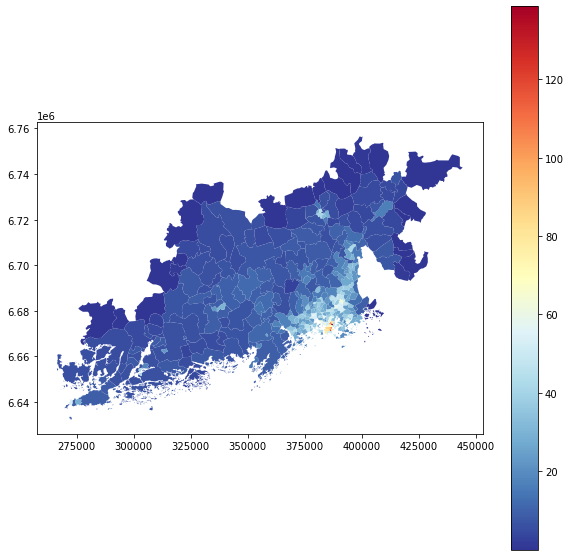

In [67]:
# Plot intersection density (number of intersections per square kilometer inside a Postal code)
m2_to_km2_converter = 1000000
postcode_areas['intersection_density'] = postcode_areas['intersection_cnt'] / (postcode_areas.area / m2_to_km2_converter)
postcode_areas.plot('intersection_density', cmap='RdYlBu_r', legend=True, figsize=(10,10))

## Nearest neighbor analysis with large datasets
While Shapely’s nearest_points -function provides a nice and easy way of conducting the nearest neighbor analysis, it can be quite slow. Using it also requires taking the unary union of the point dataset where all the Points are merged into a single layer. This can be a really memory hungry and slow operation, that can cause problems with large point datasets.

Luckily, there is a much faster and memory efficient alternatives for conducting nearest neighbor analysis, based on a function called BallTree from a scikit-learn library. The Balltree algorithm has some nice features, such as the ability to calculate the distance between neighbors with various different distance metrics. Most importantly the function allows to calculate euclidian distance between neighbors (good if your data is in metric crs), as well as haversine distance which allows to determine Great Circle distances between locations (good if your data is in lat/lon format). Note: There is also an algorithm called KDTree in scikit-learn, that is also highly efficient but less flexible in terms of supported distance metrics.

### Motivation
In this tutorial, we go through a very practical example that relates to our daily commute: Where is the closest public transport stop from my place of living? Hence, our aim is to search for each building in Helsinki Region (around 159 000 buildings) the closest public transport stop (~ 8400 stops). The building points have been fetched from OpenStreetMap using a library called OSMnx (we will learn more about this library later), and the public transport stops have been fetched from open GTFS dataset for Helsinki Region that contains information about public transport stops, schedules etc.

### Efficient nearest neighbor search with Geopandas and scikit-learn
The following examples show how to conduct nearest neighbor analysis efficiently with large datasets. We will first define the functions and see how to use them, and then we go through the code to understand what happened.

Let’s first read the datasets into Geopandas. In case of reading the building data, we will here learn a trick how to read the data directly from a ZipFile. It is very practical to know how to do this, as compressing large datasets is a very common procedure.

In [68]:
import geopandas as gpd
from zipfile import ZipFile
import io

def read_gdf_from_zip(zip_fp):
    """
    Reads a spatial dataset from ZipFile into GeoPandas. Assumes that there is only a single file (such as GeoPackage) 
    inside the ZipFile.
    """
    with ZipFile(zip_fp) as z:
        # Lists all files inside the ZipFile, here assumes that there is only a single file inside
        layer = z.namelist()[0]
        data = gpd.read_file(io.BytesIO(z.read(layer)))
    return data

# Filepaths
stops = gpd.read_file('data/pt_stops_helsinki.gpkg')
buildings = read_gdf_from_zip('data/building_points_helsinki.zip')

In [70]:
print(buildings.head())
print('----------')
print(stops.head())

             name                   geometry
0            None  POINT (24.85584 60.20727)
1     Uimastadion  POINT (24.93045 60.18882)
2            None  POINT (24.95113 60.16994)
3  Hartwall Arena  POINT (24.92918 60.20570)
4           Talli  POINT (24.92607 60.21346)
----------
     stop_name   stop_lat   stop_lon  stop_id                   geometry
0  Ritarihuone  60.169460  24.956670  1010102  POINT (24.95667 60.16946)
1   Kirkkokatu  60.171270  24.956570  1010103  POINT (24.95657 60.17127)
2   Kirkkokatu  60.170293  24.956721  1010104  POINT (24.95672 60.17029)
3    Vironkatu  60.172580  24.956554  1010105  POINT (24.95655 60.17258)
4    Vironkatu  60.172990  24.956380  1010106  POINT (24.95638 60.17299)


Okay, so both of our datasets consisting points, and based on the coordinates, they seem to be in WGS84 projection.

Let’s also make maps out of them to get a better understanding of the data

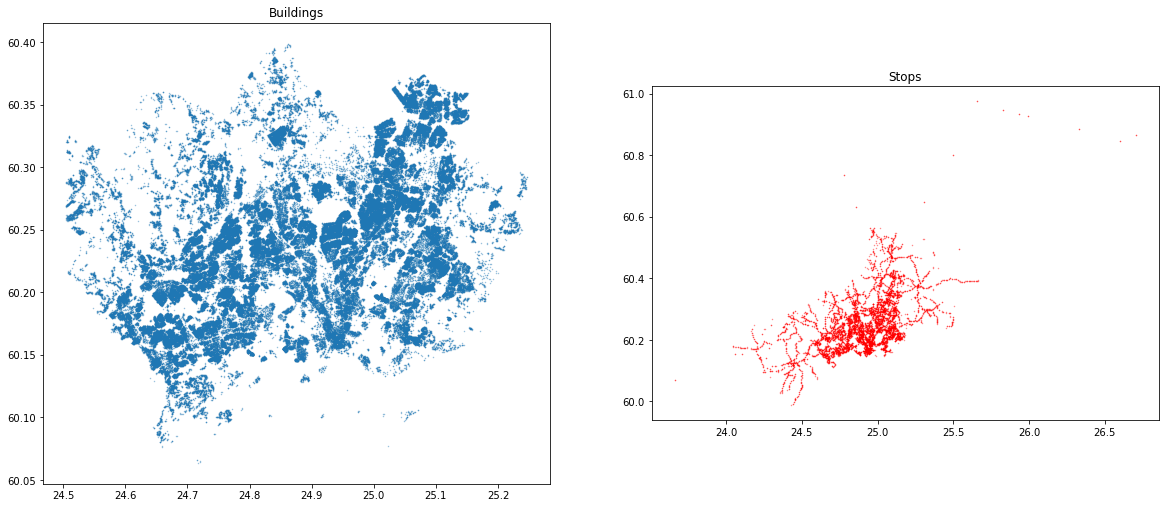

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Plot buildings
buildings.plot(ax=axes[0],markersize=0.2, alpha=0.5)
axes[0].set_title('Buildings')

# Plot stops
stops.plot(ax=axes[1], markersize=0.2, alpha=0.5, color='red')
axes[1].set_title('Stops');

As we can see, we have a very densely distributed Point dataset that shows the location of the buildings (their centroid) in Helsinki Region. On the right, we have public transport stops that seem to cover a bit broader geographical extent with a few train stops reaching further North. Most importantly, we can see from the coordinates and the map that both of the layers share the same coordinate reference system, and they are approximately from the same geographical region. Hence, we are ready to find closest public transport stop (on the right) for each building on the left map.

Let’s first prepare a couple of functions that does the work

In [73]:
from sklearn.neighbors import BallTree
import numpy as np

def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    
    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """
    
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name
    
    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
    
    # Parse coordinates from points and insert them into a numpy array as RADIANS
    # Notice: should be in Lat/Lon format 
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.y * np.pi / 180, geom.x * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.y * np.pi / 180, geom.x * np.pi / 180)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)
    
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]
    
    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)
    
    # Add distance if requested 
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
        
    return closest_points

In [74]:
# Find closest public transport stop for each building and get also the distance based on haversine distance 
# Note: haversine distance which is implemented here is a bit slower than using e.g. 'euclidean' metric 
# but useful as we get the distance between points in meters
closest_stops = nearest_neighbor(buildings, stops, return_dist=True)

# And the result looks like ..
closest_stops

,stop_name,stop_lat,stop_lon,stop_id,geometry,distance
0,Muusantori,60.20749,24.857450,1304138,POINT (24.85745 60.20749),92.374498
1,Auroran sairaala,60.19145,24.925540,1171122,POINT (24.92554 60.19145),399.238170
2,Senaatintori,60.16901,24.950460,1020450,POINT (24.95046 60.16901),109.608289
3,Veturitie,60.20661,24.929680,1174112,POINT (24.92968 60.20661),104.437950
4,Posti 1,60.21345,24.917550,1172143,POINT (24.91755 60.21345),470.640839
...,...,...,...,...,...,...
158726,Samis,60.21369,24.720970,3170209,POINT (24.72097 60.21369),195.069355
158727,Yrjö Liipolan tie,60.20922,24.695470,3170244,POINT (24.69547 60.20922),136.666774
158728,Kandidaatintie,60.21818,24.736987,3170245,POINT (24.73699 60.21818),135.041718
158729,Uimahalli,60.21638,24.711260,3170212,POINT (24.71126 60.21638),99.078476


In [75]:
# Now we should have exactly the same number of closest_stops as we have buildings
print(len(closest_stops), '==', len(buildings))

158731 == 158731


### What did we just do? Explanation.
To get a bit more understanding of what just happened, let’s go through the essential parts of the two functions we defined earlier, i.e. nearest_neighbor() and get_closest().

The purpose of nearest_neighbor() function is to handle and transform the data from GeoDataFrame into numpy arrays (=super-fast data structure) in a format how BallTree function wants them. This includes converting the lat/lon coordinates into radians (and back), so that we get the distances between the neighboring points in a correct format: scikit-learn’s haversine distance metric wants inputs as radians and also outputs the data as radians. To convert a lat/lon coordinate to radian, we use formula: Radian = Degree * PI / 180. By doing this, we are able to get the output distance information in meters (even if our coordinates are in decimal degrees).

The get_closest() function does the actual nearest neighbor search using BallTree function. We initialize the BallTree object with the coordinate information from the right_gdf (i.e. the point dataset that contains all the nearest neighbor candidates), and we specify the distance metric to be haversine so that we get the Great Circle Distances. The leaf_size parameter adjusts the tradeoff between the cost of BallTree node traversal and the cost of a brute-force distance estimate. Changing leaf_size will not affect the results of a query, but can significantly impact the speed of a query and the memory required to store the constructed tree. We determine the leaf_size as 15 which has been found to be a good compromise when benchmarked. After we have built (initialized) the ball-tree, we run the nearest neighbor query with tree.query(src_points, k=k_neighbors), where the src_points are the building-coordinates (as radians) and the k -parameter is the number of neighbors we want to calculate (1 in our case as we are only interested in the closest neighbor). Finally, we just re-arrange the data back into a format in which the closest point indices and distances are in separate numpy arrays.

Note: The functions here assume that your input points are in WGS84 projection. If you pass the points in some other projection, it is highly likely that the distances between nearest neighbors are incorrect. Determining which is the nearest neighbor should not be affected, though.

### Combining the neighboring datasets
Okay, now as we have found closest stop for each building in the region, we can easily merge the information about closest stops back to the building layer. The order of the closest_stops matches exactly the order in buildings, so we can easily merge the datasets based on index.

In [77]:
# Rename the geometry of closest stops gdf so that we can easily identify it
closest_stops = closest_stops.rename(columns={'geometry': 'closest_stop_geom'})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
buildings = buildings.join(closest_stops)

# Let's see what we have
buildings.head()

,name,geometry,stop_name,stop_lat,stop_lon,stop_id,closest_stop_geom,distance
0,None,POINT (24.85584 60.20727),Muusantori,60.20749,24.85745,1304138,POINT (24.85745 60.20749),92.374498
1,Uimastadion,POINT (24.93045 60.18882),Auroran sairaala,60.19145,24.92554,1171122,POINT (24.92554 60.19145),399.238170
2,None,POINT (24.95113 60.16994),Senaatintori,60.16901,24.95046,1020450,POINT (24.95046 60.16901),109.608289
3,Hartwall Arena,POINT (24.92918 60.20570),Veturitie,60.20661,24.92968,1174112,POINT (24.92968 60.20661),104.437950
4,Talli,POINT (24.92607 60.21346),Posti 1,60.21345,24.91755,1172143,POINT (24.91755 60.21345),470.640839


Excellent! Now we have useful information for each building about the closest stop including the distance (in meters) and also e.g. the name of the stop in stop_name column.

Now it is easy to do some descriptive analysis based on this dataset, that gives information about levels of access to public transport in the region:

In [78]:
buildings['distance'].describe()

count    158731.000000
mean        228.708617
std         292.312344
min           0.741216
25%          99.641666
50%         163.507667
75%         259.826284
max        7684.884105
Name: distance, dtype: float64

Okay, as we can see the average distance to public transport in the region is around 300 meters. More than 75 % of the buildings seem to be within within 5 minute walking time (~370 meters with walking speed of 4.5 kmph) which indicates generally a good situation in terms of accessibility levels in the region overall. There seem to be some really remote buildings in the data as well, as the longest distance to closest public transport stop is more than 7 kilometers.

Let’s make a map out of the distance information to see if there are some spatial patterns in the data in terms of accessibility levels:

<AxesSubplot:>

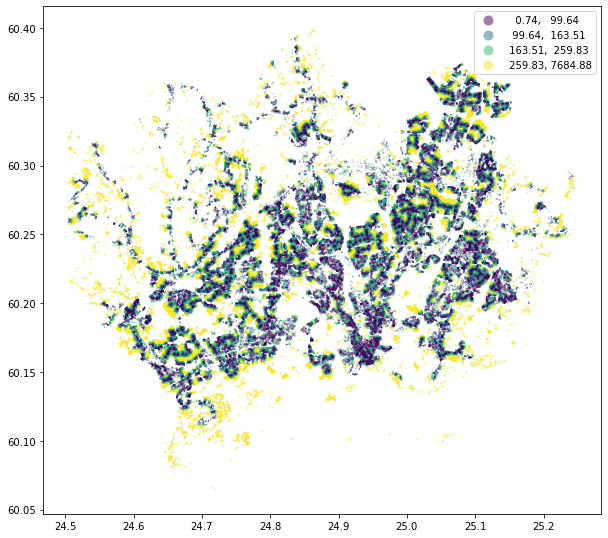

In [87]:
buildings.plot(column='distance', markersize=0.2, alpha=0.5, figsize=(10,10), scheme='quantiles', k=4, 
               legend=True)

Okay, as we can see, there are some clear spatial patterns in the levels of access to public transport. The buildings with the shortest distances (i.e. best accessibility) are located in the densely populated areas, whereas the buildings locating in the periferial areas (such as islands on the South, and nature areas in the North-West) tend to have longer distance to public transport.

### Are the results correct? Validation
As a final step, it’s good to ensure that our functions are working as they should. This can be done easily by examining the data visually.

Let’s first create LineStrings between the building and closest stop points:

In [82]:
from shapely.geometry import LineString

# Create a link (LineString) between building and stop points
buildings['link'] = buildings.apply(lambda row: LineString([row['geometry'], row['closest_stop_geom']]), axis=1)

# Set link as the active geometry
building_links = buildings.copy()
building_links = building_links.set_geometry('link')

C:\Users\alfoldybalint\.conda\envs\python_gis\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [83]:
building_links

,name,geometry,stop_name,stop_lat,stop_lon,stop_id,closest_stop_geom,distance,link
0,None,POINT (24.85584 60.20727),Muusantori,60.20749,24.857450,1304138,POINT (24.85745 60.20749),92.374498,"LINESTRING (24.85584 60.20727, 24.85745 60.20749)"
1,Uimastadion,POINT (24.93045 60.18882),Auroran sairaala,60.19145,24.925540,1171122,POINT (24.92554 60.19145),399.238170,"LINESTRING (24.93045 60.18882, 24.92554 60.19145)"
2,None,POINT (24.95113 60.16994),Senaatintori,60.16901,24.950460,1020450,POINT (24.95046 60.16901),109.608289,"LINESTRING (24.95113 60.16994, 24.95046 60.16901)"
3,Hartwall Arena,POINT (24.92918 60.20570),Veturitie,60.20661,24.929680,1174112,POINT (24.92968 60.20661),104.437950,"LINESTRING (24.92918 60.20570, 24.92968 60.20661)"
4,Talli,POINT (24.92607 60.21346),Posti 1,60.21345,24.917550,1172143,POINT (24.91755 60.21345),470.640839,"LINESTRING (24.92607 60.21346, 24.91755 60.21345)"
...,...,...,...,...,...,...,...,...,...
158726,None,POINT (24.72412 60.21448),Samis,60.21369,24.720970,3170209,POINT (24.72097 60.21369),195.069355,"LINESTRING (24.72412 60.21448, 24.72097 60.21369)"
158727,None,POINT (24.69794 60.20930),Yrjö Liipolan tie,60.20922,24.695470,3170244,POINT (24.69547 60.20922),136.666774,"LINESTRING (24.69794 60.20930, 24.69547 60.20922)"
158728,None,POINT (24.73825 60.21922),Kandidaatintie,60.21818,24.736987,3170245,POINT (24.73699 60.21818),135.041718,"LINESTRING (24.73825 60.21922, 24.73699 60.21818)"
158729,Granhultsskolan,POINT (24.71299 60.21662),Uimahalli,60.21638,24.711260,3170212,POINT (24.71126 60.21638),99.078476,"LINESTRING (24.71299 60.21662, 24.71126 60.21638)"


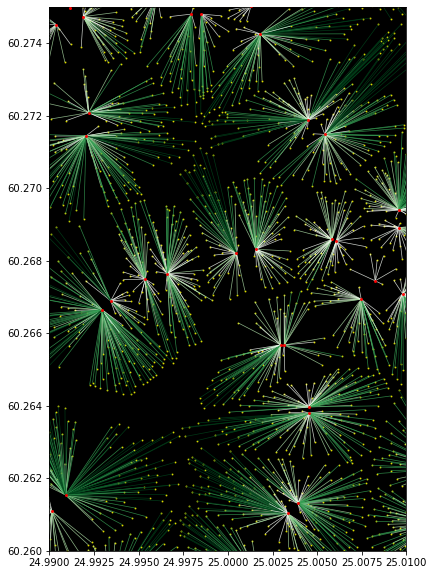

In [88]:
# Plot the connecting links between buildings and stops and color them based on distance
ax = building_links.plot(column='distance', cmap='Greens', scheme='quantiles', k=4, alpha=0.8, lw=0.7, figsize=(13, 10))
ax = buildings.plot(ax=ax, color='yellow', markersize=1, alpha=0.7)
ax = stops.plot(ax=ax, markersize=4, marker='o', color='red', alpha=0.9, zorder=3)

# Zoom closer
ax.set_xlim([24.99, 25.01])
ax.set_ylim([60.26, 60.275])

# Set map background color to black, which helps with contrast
ax.set_facecolor('black')